In [1]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get Images

In [2]:
MNIST_PATH = './Dataset/'

In [3]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [4]:
#Training set
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

##Validation set
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

##Test set
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

## Normalize images

In [5]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [6]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [7]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

## Show Images

In [8]:
x_test.shape

(10000, 784)

In [9]:
y_train.shape

(50000, 1)

In [10]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 1


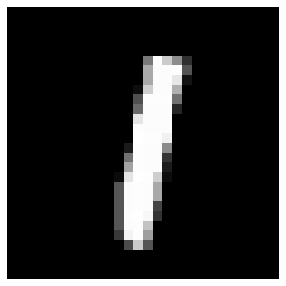

In [11]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Create Mini Batches

In [12]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, input_layer
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Pytorch 

In [13]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

## Use GPU when available

In [14]:
torch.cuda.is_available()

True

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Accuracy

In [16]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

# Train

In [17]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    epoch_acc = 0.0
    i = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (epoch_acc < 0.95 and i<100):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr_list.append(optimizer.param_groups[0]['lr'])
        i+=1
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        #print(f'Epoch: {len(acc_list)}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list

# Experiments

Global var

In [18]:
layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

# Fixed

In [19]:
modelFixed = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimizer = torch.optim.SGD(modelFixed.parameters(), lr=lr)


start.record()
fixed_acc_list, fixed_cost_list, fixed_lr_list = train(modelFixed, optimizer,None, mb_size)
end.record()

torch.cuda.synchronize()
fixed_time = round((start.elapsed_time(end)/1000)/len(fixed_acc_list),2)


In [20]:
fixed_acc = accuracy(modelFixed, x_test_tensor,  y_test_tensor, mb_size)

# Cyclic

## Cyclic Vanilla

In [21]:
modelCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimizer = torch.optim.SGD(modelCyclic.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

start.record()
cyclic_acc_list, cyclic_cost_list, cyclic_lr_list= train(modelCyclic, optimizer,scheduler, mb_size)
end.record()

torch.cuda.synchronize()
cyclic_time = round((start.elapsed_time(end)/1000)/len(cyclic_acc_list),2)


In [22]:
cyclic_acc = accuracy(modelCyclic, x_test_tensor,  y_test_tensor, mb_size)

## Cyclic Class

In [23]:
from torch.optim import Optimizer

import types
import math
from torch._six import inf
from functools import wraps
import warnings
import weakref
import random

class _LRSchedulerGiselt_Denis(object):

    def __init__(self, optimizer, last_epoch=-1, verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Initialize epoch and base learning rates
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]
        self.last_epoch = last_epoch

        # Following https://github.com/pytorch/pytorch/issues/20124
        # We would like to ensure that `lr_scheduler.step()` is called after
        # `optimizer.step()`
        def with_counter(method):
            if getattr(method, '_with_counter', False):
                # `optimizer.step()` has already been replaced, return.
                return method

            # Keep a weak reference to the optimizer instance to prevent
            # cyclic references.
            instance_ref = weakref.ref(method.__self__)
            # Get the unbound method for the same purpose.
            func = method.__func__
            cls = instance_ref().__class__
            del method

            @wraps(func)
            def wrapper(*args, **kwargs):
                instance = instance_ref()
                instance._step_count += 1
                wrapped = func.__get__(instance, cls)
                return wrapped(*args, **kwargs)

            # Note that the returned function here is no longer a bound method,
            # so attributes like `__func__` and `__self__` no longer exist.
            wrapper._with_counter = True
            return wrapper

        self.optimizer.step = with_counter(self.optimizer.step)
        self.verbose = verbose

        self._initial_step()

    def _initial_step(self):
        """Initialize step counts and performs a step"""
        self.optimizer._step_count = 0
        self._step_count = 0
        self.step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Args:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_last_lr(self):
        """ Return last computed learning rate by current scheduler.
        """
        return self._last_lr

    def get_lr(self):
        # Compute learning rate using chainable form of the scheduler
        raise NotImplementedError

    def print_lr(self, is_verbose, group, lr, epoch=None):
        """Display the current learning rate.
        """
        if is_verbose:
            if epoch is None:
                print('Adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(group, lr))
            else:
                epoch_str = ("%.2f" if isinstance(epoch, float) else
                             "%.5d") % epoch
                print('Epoch {}: adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(epoch_str, group, lr))


    def step(self, epoch=None):
        # Raise a warning if old pattern is detected
        # https://github.com/pytorch/pytorch/issues/20124
        if self._step_count == 1:
            if not hasattr(self.optimizer.step, "_with_counter"):
                warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
                              "initialization. Please, make sure to call `optimizer.step()` before "
                              "`lr_scheduler.step()`. See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

            # Just check if there were two first lr_scheduler.step() calls before optimizer.step()
            elif self.optimizer._step_count < 1:
                warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
                              "In PyTorch 1.1.0 and later, you should call them in the opposite order: "
                              "`optimizer.step()` before `lr_scheduler.step()`.  Failure to do this "
                              "will result in PyTorch skipping the first value of the learning rate schedule. "
                              "See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
        self._step_count += 1

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False

        with _enable_get_lr_call(self):
            if epoch is None:
                self.last_epoch += 1
                values = self.get_lr()
            else:
                warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
                self.last_epoch = epoch
                if hasattr(self, "_get_closed_form_lr"):
                    values = self._get_closed_form_lr()
                else:
                    values = self.get_lr()

        for i, data in enumerate(zip(self.optimizer.param_groups, values)):
            param_group, lr = data
            param_group['lr'] = lr
            self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

class CyclicLRGiselt_Denis(_LRSchedulerGiselt_Denis):
    r"""Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.

    Cyclical learning rate policy changes the learning rate after every batch.
    `step` should be called after a batch has been used for training.

    This class has three built-in policies, as put forth in the paper:

    * "triangular": A basic triangular cycle without amplitude scaling.
    * "triangular2": A basic triangular cycle that scales initial amplitude by half each cycle.
    * "exp_range": A cycle that scales initial amplitude by :math:`\text{gamma}^{\text{cycle iterations}}`
      at each cycle iteration.

    This implementation was adapted from the github repo: `bckenstler/CLR`_

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for each parameter group.
        max_lr (float or list): Upper learning rate boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size_up (int): Number of training iterations in the
            increasing half of a cycle. Default: 2000
        step_size_down (int): Number of training iterations in the
            decreasing half of a cycle. If step_size_down is None,
            it is set to step_size_up. Default: None
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            If specified, then 'mode' is ignored.
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        cycle_momentum (bool): If ``True``, momentum is cycled inversely
            to learning rate between 'base_momentum' and 'max_momentum'.
            Default: True
        base_momentum (float or list): Lower momentum boundaries in the cycle
            for each parameter group. Note that momentum is cycled inversely
            to learning rate; at the peak of a cycle, momentum is
            'base_momentum' and learning rate is 'max_lr'.
            Default: 0.8
        max_momentum (float or list): Upper momentum boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_momentum - base_momentum).
            The momentum at any cycle is the difference of max_momentum
            and some scaling of the amplitude; therefore
            base_momentum may not actually be reached depending on
            scaling function. Note that momentum is cycled inversely
            to learning rate; at the start of a cycle, momentum is 'max_momentum'
            and learning rate is 'base_lr'
            Default: 0.9
        last_epoch (int): The index of the last batch. This parameter is used when
            resuming a training job. Since `step()` should be invoked after each
            batch instead of after each epoch, this number represents the total
            number of *batches* computed, not the total number of epochs computed.
            When last_epoch=-1, the schedule is started from the beginning.
            Default: -1
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.

    Example:
        >>> # xdoctest: +SKIP
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         train_batch(...)
        >>>         scheduler.step()


    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self,
                 optimizer,
                 base_lr,
                 max_lr,
                 step_size_up=2000,
                 step_size_down=None,
                 mode='triangular',
                 gamma=1.,
                 scale_fn=None,
                 scale_mode='cycle',
                 cycle_momentum=True,
                 base_momentum=0.8,
                 max_momentum=0.9,
                 last_epoch=-1,
                 verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        
        self.direction_up = True
        self.half_cycle_steps = 0

        base_lrs = self._format_param('base_lr', optimizer, base_lr)
        if last_epoch == -1:
            for lr, group in zip(base_lrs, optimizer.param_groups):
                group['lr'] = lr

        self.max_lrs = self._format_param('max_lr', optimizer, max_lr)

        self.step_size_up = float(step_size_up)
        self.step_size_down = float(step_size_down) if step_size_down is not None else step_size_up
        self.total_size = self.step_size_up + self.step_size_down
        self.step_ratio = step_size_up / self.total_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            self._scale_fn_custom = None
            if self.mode == 'triangular':
                self._scale_fn_ref = weakref.WeakMethod(self._triangular_scale_fn)
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self._scale_fn_ref = weakref.WeakMethod(self._triangular2_scale_fn)
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self._scale_fn_ref = weakref.WeakMethod(self._exp_range_scale_fn)
                self.scale_mode = 'iterations'
        else:
            self._scale_fn_custom = scale_fn
            self._scale_fn_ref = None
            self.scale_mode = scale_mode

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
            self.base_momentums = [group['momentum'] for group in optimizer.param_groups]
            self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)

        super(CyclicLRGiselt_Denis, self).__init__(optimizer, last_epoch, verbose)
        self.base_lrs = base_lrs

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def scale_fn(self, x):
        if self._scale_fn_custom is not None:
            # print(self.half_cycle_steps, x)
            return self._scale_fn_custom(x)

        else:
            return self._scale_fn_ref()(x)

    def scale_fn_rand(self, x, y):
        return random.uniform(x, y)

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        """Calculates the learning rate at batch index. This function treats
        `self.last_epoch` as the last batch index.

        If `self.cycle_momentum` is ``True``, this function has a side effect of
        updating the optimizer's momentum.
        """
        

        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        cycle = math.floor(1 + self.last_epoch / self.total_size)
        x = 1. + self.last_epoch / self.total_size - cycle
        if x <= self.step_ratio:
            scale_factor = x / self.step_ratio
        else:
            scale_factor = (x - 1) / (self.step_ratio - 1)

        lrs = []
        for base_lr, max_lr in zip(self.base_lrs, self.max_lrs):
            base_height = (max_lr - base_lr) * scale_factor
            if self.scale_mode == 'cycle':

                # print("cycle")
                lr = base_lr + base_height * self.scale_fn(cycle)
            elif self.scale_mode == 'iterations':

                # print("iterations")
                lr = base_lr + base_height * self.scale_fn(self.last_epoch)

            elif self.scale_mode == 'decrecimiento':
                if (self.last_epoch == 0):
                  lr = max_lr
                else: 
                  lr = self.get_last_lr()[0] - base_lr
                  if (lr<0):
                    lr = base_lr

            elif self.scale_mode == 'chipichipi':                               #<--------------------------
                
                '''
                for x in optimizer.param_groups:
                  for each in x['params']:
                    print(each)
                
                for name, param in modelBB.named_parameters():
                  print(param.grad.shape)
                '''

                # print("chipichipi")
                if (self.last_epoch == 0):
                    last_lr = base_lr
                else:
                    last_lr = self.get_last_lr()[0]
                    # print(f"Esto es el ultimo lr {last_lr}")

                if (self.half_cycle_steps == self.step_size_up
                    and self.direction_up == True):
                    #print('Cambio de direccion: bajando')
                    lr = random.uniform(last_lr, max_lr)
                    self.direction_up = False
                    self.half_cycle_steps = 1

                elif (self.half_cycle_steps == self.step_size_down
                    and self.direction_up == False):
                    #print('Cambio de direccion: subiendo')
                    lr = random.uniform(base_lr, last_lr)
                    self.direction_up = True
                    self.half_cycle_steps = 1

                elif (self.direction_up == True):
                    lr = random.uniform(last_lr, max_lr)
                    self.half_cycle_steps += 1

                elif(self.direction_up == False):
                    lr = random.uniform(base_lr, last_lr)
                    self.half_cycle_steps += 1
            #print('base_lr: '+str(base_lr))
            lrs.append(lr)

        if self.cycle_momentum:
            #print('wowo')
            momentums = []
            for base_momentum, max_momentum in zip(self.base_momentums, self.max_momentums):
                base_height = (max_momentum - base_momentum) * scale_factor
                if self.scale_mode == 'cycle':
                    momentum = max_momentum - base_height * self.scale_fn(cycle)
                else:
                    momentum = max_momentum - base_height * self.scale_fn(self.last_epoch)
                #print('momentum: '+str(max_momentum)+' '+str(base_momentum))
                momentums.append(momentum)
            for param_group, momentum in zip(self.optimizer.param_groups, momentums):
                param_group['momentum'] = momentum
            
        return lrs

## Random Cyclic

In [24]:
import random

modelRandomCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimizer = torch.optim.SGD(modelRandomCyclic.parameters(), lr=lr)

clr_fn = lambda x, y: random.uniform(x, y)

scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=3, scale_fn=clr_fn,scale_mode='chipichipi', cycle_momentum=False)

start.record()
random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list= train(modelRandomCyclic, optimizer,scheduler, mb_size)
end.record()

torch.cuda.synchronize()
random_cyclic_time = round((start.elapsed_time(end)/1000)/len(random_cyclic_acc_list),2)

In [25]:
random_cyclic_acc = accuracy(modelRandomCyclic, x_test_tensor,  y_test_tensor, mb_size)

# Decreciente

In [26]:
modelDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimizer = torch.optim.SGD(modelDecay.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1, verbose=False)
scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=1, scale_fn=clr_fn,scale_mode='decrecimiento', cycle_momentum=False)

start.record()
decay_acc_list, decay_cost_list, decay_lr_list = train(modelDecay,optimizer, scheduler, mb_size)
end.record()

torch.cuda.synchronize()
decay_time = round((start.elapsed_time(end)/1000)/len(decay_acc_list),2)


In [27]:
decay_acc = accuracy(modelDecay, x_test_tensor,  y_test_tensor, mb_size)

#L-BFGS

## L-BFGS

In [28]:
modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))

optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
                              lr=1,
                              history_size=10, #update history size. What's this?
                              max_iter=1, #maximal number of iterations per optimization step
                              #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                              #line_search_fn="strong_wolfe"
                              )

lbfgs_cost_list = [0.0]
lbfgs_acc_list = [0.0]
modelLBFGS = modelLBFGS.to(device=device)
x_train_tensor = x_train_tensor.to(device=device, dtype=torch.float32)
y_train_tensor = y_train_tensor.to(device=device, dtype=torch.long)
i = 0

start.record()
#training
while (lbfgs_acc_list[-1] < 0.95):
  #print('Iteracion: '+ str(i))
  def closure():
    optimizer.zero_grad()
    scores = modelLBFGS(x_train_tensor)
    cost = F.cross_entropy(input= scores, target=y_train_tensor.squeeze())
    cost.backward()
    #print(f'costo: {cost.item()}')
    return cost
  lbfgs_cost_list.append(optimizer.step(closure))
  lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size))
  #print(f'accuracy: {lbfgs_acc_list[-1]}')
  i+=1
end.record()

torch.cuda.synchronize()
lbfgs_time = round((start.elapsed_time(end)/1000)/len(lbfgs_acc_list),2)


In [29]:
lbfgs_acc = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

## L-BFGS with line search

In [30]:
modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))

optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
                              lr=1,
                              history_size=10, #update history size. What's this?
                              max_iter=1, #maximal number of iterations per optimization step
                              #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                              line_search_fn="strong_wolfe"
                              )

lbfgs_ls_cost_list = [0.0]
lbfgs_ls_acc_list = [0.0]
modelLBFGS_LS = modelLBFGS_LS.to(device=device)
x_train_tensor = x_train_tensor.to(device=device, dtype=torch.float32)
y_train_tensor = y_train_tensor.to(device=device, dtype=torch.long)
i = 0

start.record()
#training
while (lbfgs_ls_acc_list[-1] < 0.95):
  #print('Iteracion: '+ str(i))
  def closure():
    optimizer.zero_grad()
    scores = modelLBFGS_LS(x_train_tensor)
    cost = F.cross_entropy(input= scores, target=y_train_tensor.squeeze())
    cost.backward()
    #print(f'costo: {cost.item()}')
    return cost

  lbfgs_ls_cost_list.append(optimizer.step(closure))
  lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size))
  #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
  i+=1
end.record()

torch.cuda.synchronize()
lbfgs_ls_time = round((start.elapsed_time(end)/1000)/len(lbfgs_ls_acc_list),2)

In [31]:
lbfgs_ls_acc = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

## Adam

In [32]:
modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
start.record()
adam_acc_list, adam_cost_list,adam_lr_list = train(modelAdam,optimiserAdam,None, mb_size)
end.record()


torch.cuda.synchronize()
adam_time = round((start.elapsed_time(end)/1000)/len(adam_acc_list),2)

In [33]:
adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

## Momentum

In [34]:
modelSGDM = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)
start.record()
SGDM_acc_list, SGDM_cost_list,SGDM_lr_list = train(modelSGDM, optimiserSGDM,None, mb_size)
end.record()

torch.cuda.synchronize()
SGDM_time = round((start.elapsed_time(end)/1000)/len(SGDM_acc_list),2)

In [35]:
SGDM_acc = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

## RMSProp

In [36]:
modelRMSP = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)
start.record()
RMSP_acc_list, RMSP_cost_list,RMSP_lr_list = train(modelRMSP, optimiserRMSP,None, mb_size)
end.record()

torch.cuda.synchronize()
RMSP_time = round((start.elapsed_time(end)/1000)/len(RMSP_acc_list),2)

In [37]:
RMSP_acc = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

# Resultados

## Traza de tasas de aprendizaje no adaptativas

C:\Users\denis\AppData\Local\Temp\ipykernel_16036\3956678165.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


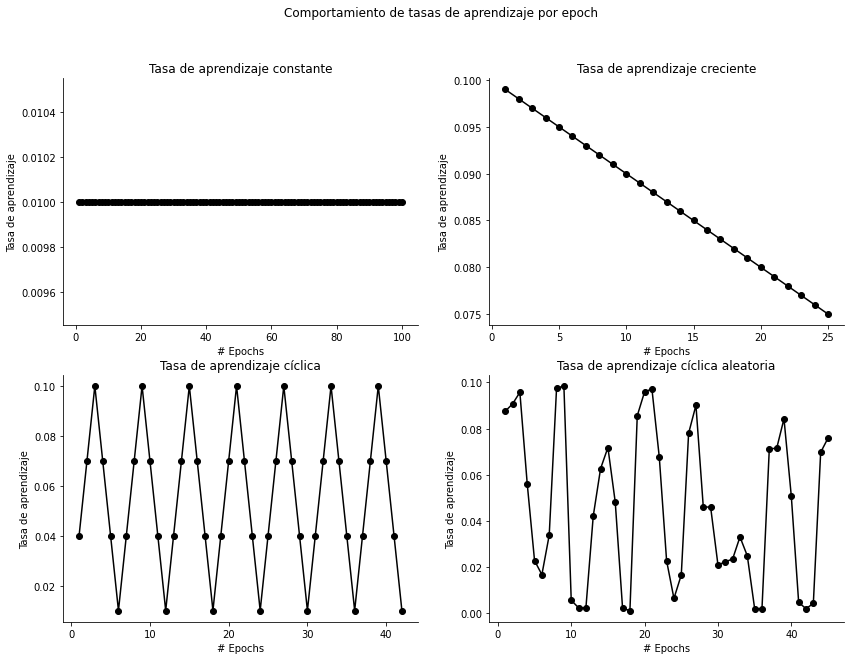

In [38]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(2,2,figsize=(14, 10))

method = [fixed_lr_list, decay_lr_list, cyclic_lr_list, random_cyclic_lr_list, adam_lr_list,SGDM_lr_list,RMSP_lr_list]
names = ['Tasa de aprendizaje constante', 'Tasa de aprendizaje creciente', 'Tasa de aprendizaje cíclica', 'Tasa de aprendizaje cíclica aleatoria', 'TA con Adam','TA con Momentum','TA con RMSProp']
i = 0
for a in range(2):
  for b in range(2):
    ax[a,b].plot(range(len(method[i]))[1:], 
            method[i][1:], 
            'black',
            marker = 'o')
    #ax[a,b].set_xlim([1, len(method[i])])
    #ax[a,b].set_ylim([0, max(method[i]) + 0.01])
    ax[a,b].set_xlabel('# Epochs') #, fontsize = 18)
    ax[a,b].set_ylabel('Tasa de aprendizaje') #, fontsize = 18)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].spines['right'].set_visible(False)
    #ax[a,b].xaxis.set_major_locator(MultipleLocator(len(method[i])//4))
    #ax[a,b].xaxis.set_minor_locator(MultipleLocator(len(method[i])//4))
    ax[a,b].set_title(names[i])
    i+=1


fig.suptitle('Comportamiento de tasas de aprendizaje por epoch')
fig.show()

## Tiempos por epoch

In [39]:
#No adaptativos
print('Fixed | '+'Epoch: '+ str(len(fixed_acc_list)) + '  accuracy: '+str(fixed_acc_list[-1]) + '  time: '+ str(fixed_time))
print('Decay | '+'Epoch: '+ str(len(decay_acc_list)) + '  accuracy: '+str(decay_acc_list[-1]) + '  time: '+ str(decay_time))
print('Cyclic | '+'Epoch: '+ str(len(cyclic_acc_list)) + '  accuracy: '+str(cyclic_acc_list[-1]) + '  time: '+ str(cyclic_time))
print('Random Cyclic | '+'Epoch: '+ str(len(random_cyclic_acc_list)) + '  accuracy: '+str(random_cyclic_acc_list[-1]) + '  time: '+ str(random_cyclic_time))
#L-BFGS
print('L-BFGS | '+'Epoch: '+ str(len(lbfgs_acc_list)) + '  accuracy: '+str(lbfgs_acc_list[-1]) + '  time: '+ str(lbfgs_time))
print('L-BFGS LS | '+'Epoch: '+ str(len(lbfgs_ls_acc_list)) + '  accuracy: '+str(lbfgs_ls_acc_list[-1]) + '  time: '+ str(lbfgs_ls_time))
#Aceleradores
print('Adam | '+'Epoch: '+ str(len(adam_acc_list)) + '  accuracy: '+str(adam_acc_list[-1]) + '  time: '+ str(adam_time))
print('SGDM | '+'Epoch: '+ str(len(SGDM_acc_list)) + '  accuracy: '+str(SGDM_acc_list[-1]) + '  time: '+ str(SGDM_time))
print('RMSP | '+'Epoch: '+ str(len(RMSP_acc_list)) + '  accuracy: '+str(RMSP_acc_list[-1]) + '  time: '+ str(RMSP_time))

Fixed | Epoch: 101  accuracy: 0.926025390625  time: 0.17
Decay | Epoch: 26  accuracy: 0.95263671875  time: 0.14
Cyclic | Epoch: 43  accuracy: 0.95458984375  time: 0.14
Random Cyclic | Epoch: 46  accuracy: 0.9501953125  time: 0.14
L-BFGS | Epoch: 33  accuracy: 0.951904296875  time: 0.1
L-BFGS LS | Epoch: 36  accuracy: 0.956298828125  time: 0.19
Adam | Epoch: 4  accuracy: 0.959228515625  time: 0.08
SGDM | Epoch: 28  accuracy: 0.951904296875  time: 0.11
RMSP | Epoch: 8  accuracy: 0.95458984375  time: 0.09


## Convergencia en iteraciones

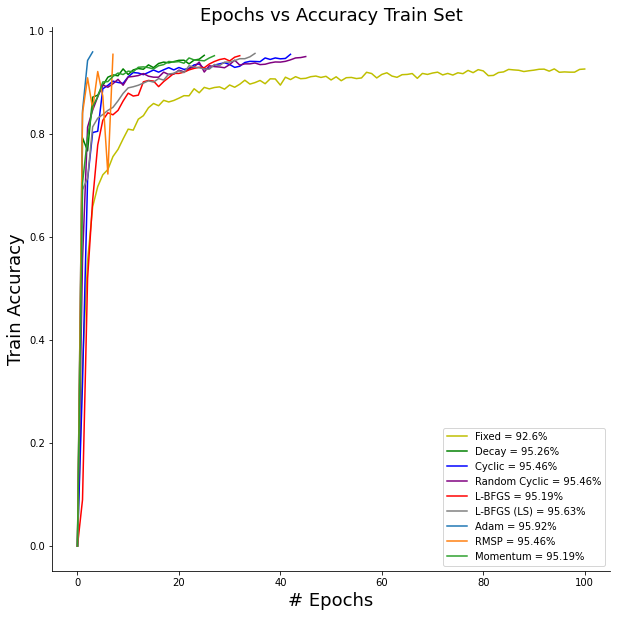

In [40]:
x_axis = range(len(decay_acc_list))
y_axis = np.linspace(0,5,10)

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(fixed_acc_list)),fixed_acc_list, 'y', label='Fixed = {acc}%'.format(acc = round(fixed_acc_list[-1] * 100 , 2)))
ax.plot(range(len(decay_acc_list)), decay_acc_list, 'g', label='Decay = {acc}%'.format(acc = round(decay_acc_list[-1] * 100, 2)))
ax.plot(range(len(cyclic_acc_list)), cyclic_acc_list, 'b', label='Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))
ax.plot(range(len(random_cyclic_acc_list)), random_cyclic_acc_list, 'purple', label='Random Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))
ax.plot(range(len(lbfgs_acc_list)), lbfgs_acc_list, 'r', label='L-BFGS = {acc}%'.format(acc = round(lbfgs_acc_list[-1] * 100, 2)))
ax.plot(range(len(lbfgs_ls_acc_list)), lbfgs_ls_acc_list, 'grey', label='L-BFGS (LS) = {acc}%'.format(acc = round(lbfgs_ls_acc_list[-1] * 100, 2)))

ax.plot(range(len(adam_acc_list)),adam_acc_list, label='Adam = {acc}%'.format(acc = round(adam_acc_list[-1] * 100 , 2)))
ax.plot(range(len(RMSP_acc_list)), RMSP_acc_list, label='RMSP = {acc}%'.format(acc = round(RMSP_acc_list[-1] * 100, 2)))
ax.plot(range(len(SGDM_acc_list)), SGDM_acc_list, label='Momentum = {acc}%'.format(acc = round(SGDM_acc_list[-1] * 100, 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)
plt.xlabel('# Epochs', fontsize = 18)
plt.ylabel('Train Accuracy', fontsize = 18)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Precision en el conjunto de datos de prueba

In [41]:
print("Tasa de aprendizaje fija| " + str(fixed_acc))
print("Tasa de aprendizaje decreciente| " + str(decay_acc))
print("Tasa de aprendizaje ciclica | " + str(cyclic_acc))
print("Tasa de aprendizaje ciclica random | " + str(random_cyclic_acc))
print("L-BFGS | " + str(lbfgs_acc))
print("L-BFGS con busqueda lineal | " + str(lbfgs_ls_acc))
print("Adam | " + str(adam_acc))
print("RMSP| " + str(RMSP_acc))
print("Momentum| " + str(SGDM_acc))

Tasa de aprendizaje fija| 0.922119140625
Tasa de aprendizaje decreciente| 0.944091796875
Tasa de aprendizaje ciclica | 0.9501953125
Tasa de aprendizaje ciclica random | 0.940185546875
L-BFGS | 0.945068359375
L-BFGS con busqueda lineal | 0.943359375
Adam | 0.9599609375
RMSP| 0.940185546875
Momentum| 0.9521484375


### Results

| --- | --- | --- |
| Stretch/Untouched | ProbDistribution | Accuracy |
| --- | --- | --- |
| Stretched | Gaussian | {{adam_acc}} |

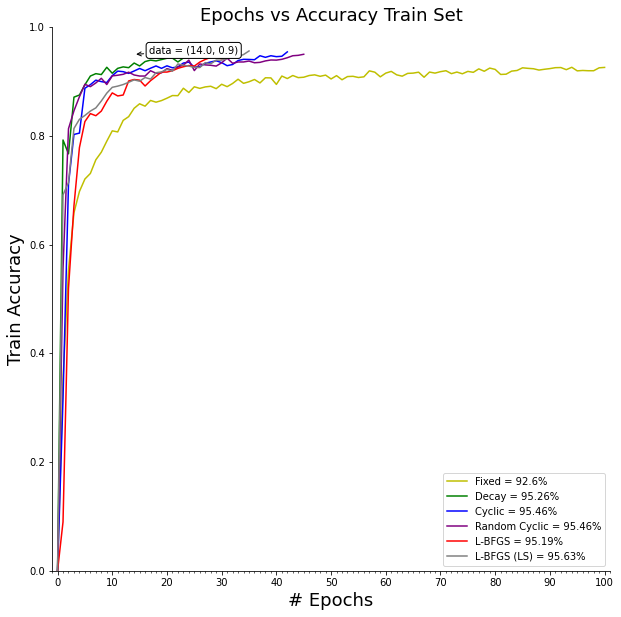

In [43]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

x_axis = range(len(decay_acc_list))
y_axis = np.linspace(0,5,10)

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(fixed_acc_list)),
        fixed_acc_list, 
        'y', 
        label='Fixed = {acc}%'.format(acc = round(fixed_acc_list[-1] * 100 , 2)))

ax.plot(range(len(decay_acc_list)), 
        decay_acc_list, 
        'g', 
        label='Decay = {acc}%'.format(acc = round(decay_acc_list[-1] * 100, 2)))

ax.plot(range(len(cyclic_acc_list)), 
        cyclic_acc_list, 
        'b', 
        label='Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))

ax.plot(range(len(random_cyclic_acc_list)), 
        random_cyclic_acc_list, 
        'purple', 
        label='Random Cyclic = {acc}%'.format(acc = round(cyclic_acc_list[-1] * 100, 2)))

ax.plot(range(len(lbfgs_acc_list)), 
        lbfgs_acc_list, 'r', 
        label='L-BFGS = {acc}%'.format(acc = round(lbfgs_acc_list[-1] * 100, 2)))

ax.plot(range(len(lbfgs_ls_acc_list)), 
        lbfgs_ls_acc_list, 
        'grey', 
        label='L-BFGS (LS) = {acc}%'.format(acc = round(lbfgs_ls_acc_list[-1] * 100, 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

ax.set_xlim([-1, len(fixed_acc_list)])
ax.set_ylim([0, 1])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
            (14, 0.95), xytext =(1 + 14,0.95),
            textcoords ='offset points',
            bbox = bbox, arrowprops = arrowprops)

plt.show()